# Fanal

## A neutrino-less beta decay experiment 

## An open exercise

## Calibration


### USC, Master de Física, Física de Partícula II


J. A. Hernando-Morata, 

with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz

February 2021


In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [3]:
import core.pltext as pltext
import core.hfit   as hfit
import core.utils  as ut

pltext.style()

## Indications

### Objective

**Estimate the energy resolution** and **the energy scale of the detector**. For that, we will fit some peaks a 208Tl calibration sample to its know tabulated energy.

### Tasks:

   * Open the data file (HDF) and access the mock calibration data (cal) obtained with a 208Tl source.

   * Fit the energy of the main track (track0) to the main photo-peak (2.615 MeV) and double-scape peak.
   
   * Fit the energy of the secon track (track1) to other Tl gamma lines
   
   * Calibrate the measured energy of the peacks with respect the tabulated energy.

### Notes:

   * The main photo-peak is at 2.615 MeV. This peak can suffer Compton, Bremsstrahlung and pear production. A double-scape peak is expected at 2.615 - 2 * 511 keV. 
  
   * There are other minor 208Tl gamma lines at 860, 583 and 511 keV. 
  
   * Sometimes the photo-peak is produced with an associated 126Xe X-ray of 30 keV.

## Access the data

In [4]:
dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'

In [5]:
filename = 'alpha.h5'

calib = pd.read_hdf(dirpath + filename, key = 'data/tl208')

### list of variables



In [6]:
calib

,E,num_tracks,num_voxels,track0_E,track0_voxels,track0_length,blob1_E,blob2_E,track1_E,track1_voxels,track1_length,zave,rmax
150373,2.591312,3.0,28,2.348921,25.0,147.251590,0.887860,0.402937,0.145855,2.0,13.900386,1061.207245,508.247354
436891,2.618989,2.0,22,2.358163,21.0,133.722617,0.844966,0.203962,0.260826,1.0,0.000000,796.508453,260.993460
402656,2.800769,3.0,23,1.938585,20.0,100.507075,0.879257,0.234195,0.597067,2.0,9.888210,843.834564,499.997923
483196,2.620657,6.0,22,1.167942,10.0,47.722996,0.750151,0.198320,0.929632,7.0,24.030093,905.682892,292.062774
542246,2.609380,3.0,28,2.102567,23.0,139.329072,0.596231,0.423940,0.260768,2.0,9.456930,994.740234,466.800406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
917560,2.655893,4.0,20,1.817673,16.0,100.367657,0.957401,0.257572,0.452571,1.0,0.000000,759.305069,475.515674
247885,2.419446,6.0,14,1.595698,8.0,27.184835,1.134718,0.348883,0.482182,2.0,9.959931,656.537766,420.968843
831255,2.692755,3.0,36,2.575684,34.0,172.888732,0.678771,0.455451,0.082786,1.0,0.000000,237.584160,496.551209
687356,2.413637,2.0,21,1.915028,19.0,60.279117,0.817436,0.068328,0.498609,2.0,9.278479,1213.646179,479.482670


## Histogram the variables

We are drawing the variables only in the relevant range (2.6, 2.8 MeV)

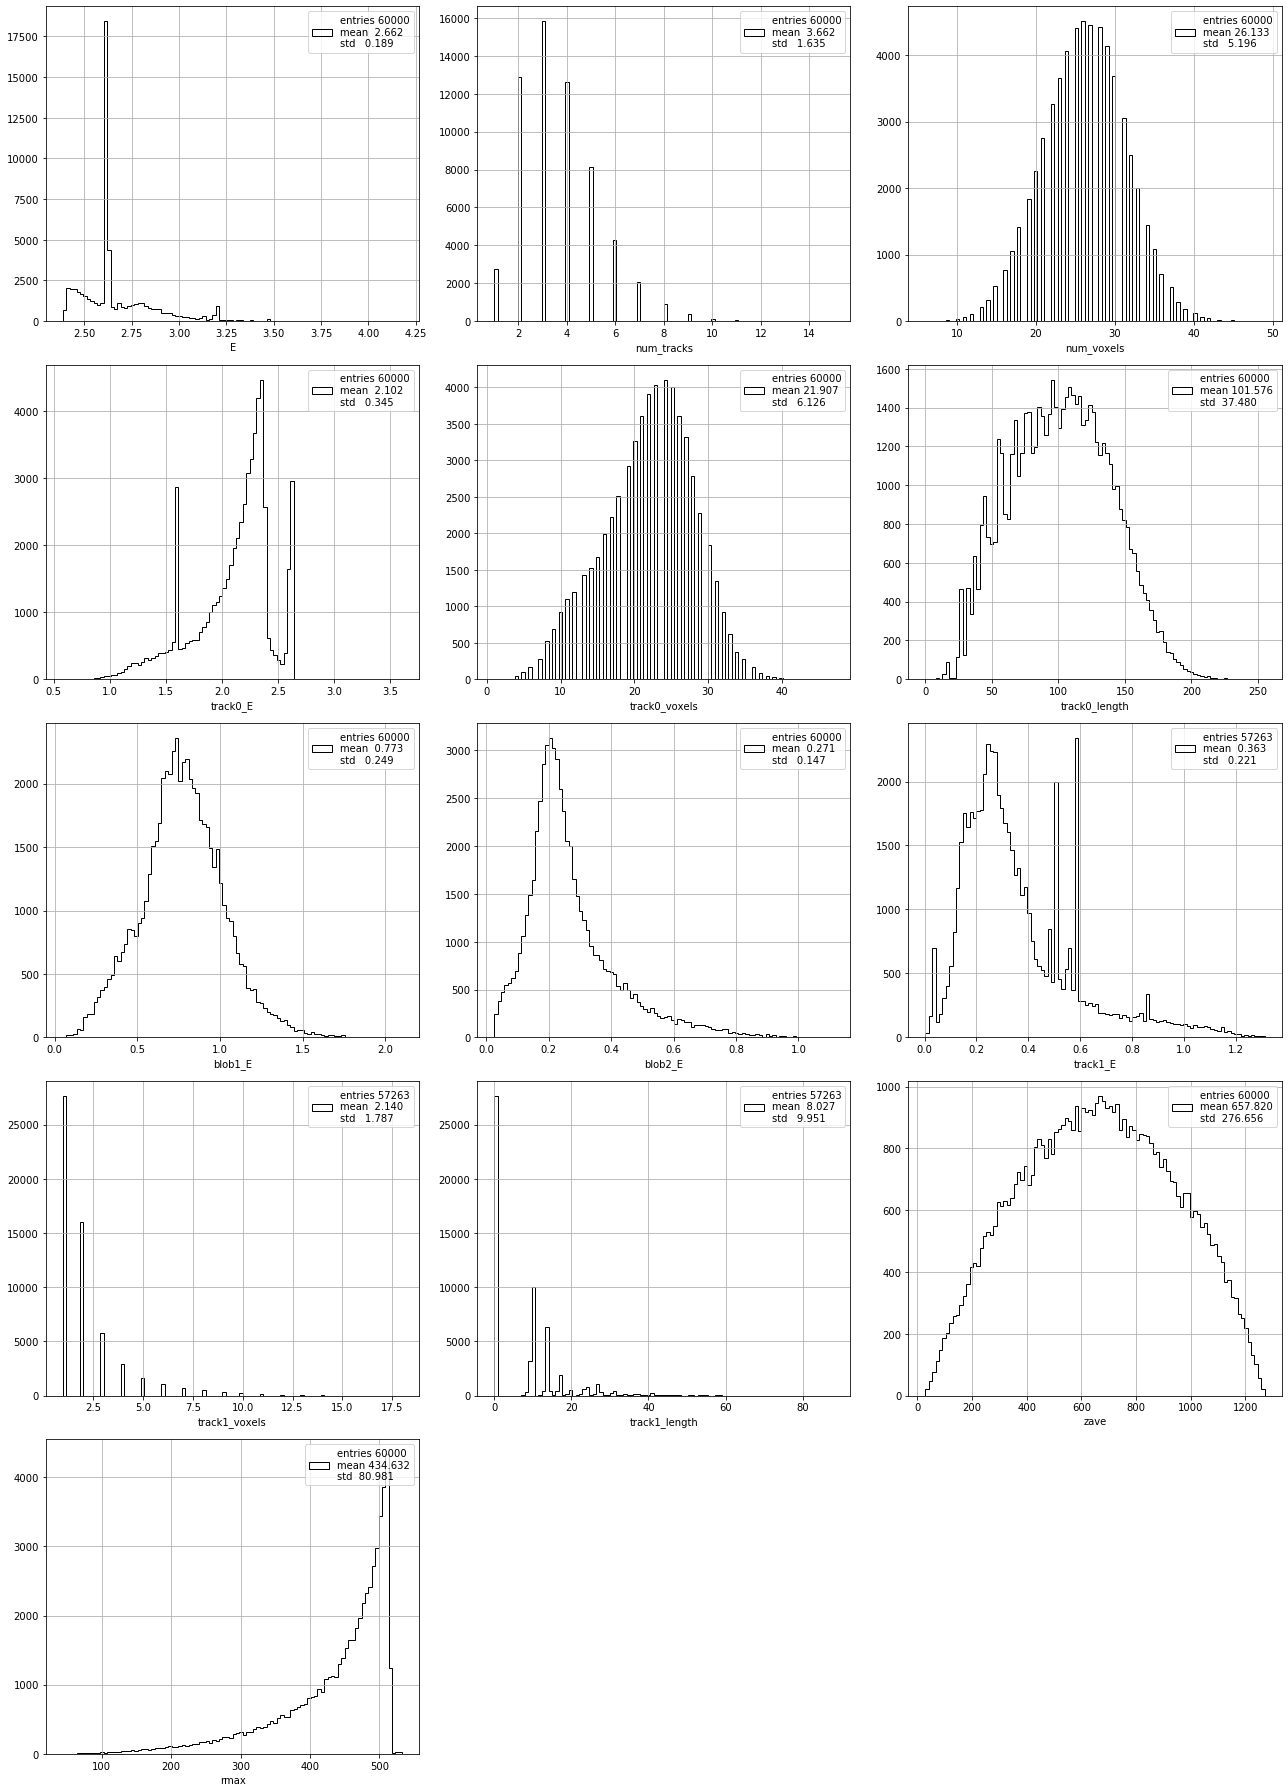

In [7]:
pltext.df_inspect(calib, ncolumns = 3)

## Energy calibration, identifying the peaks

In [8]:
# utitility function
def efit(enes, bins, erange, guess = None):
    guess  = (len(enes), np.mean(enes), 20., 10., 0.) if guess is None else guess
    sel    = ut.in_range(enes, erange)
    pars, cpars = pltext.hfit(enes[sel], bins, fun = 'gausline', guess = guess, range = erange);
    return pars, cpars

### Photo-peak and double-escape

Study the energy of the track-0.

Fit the photo-peak and the double-escape peak

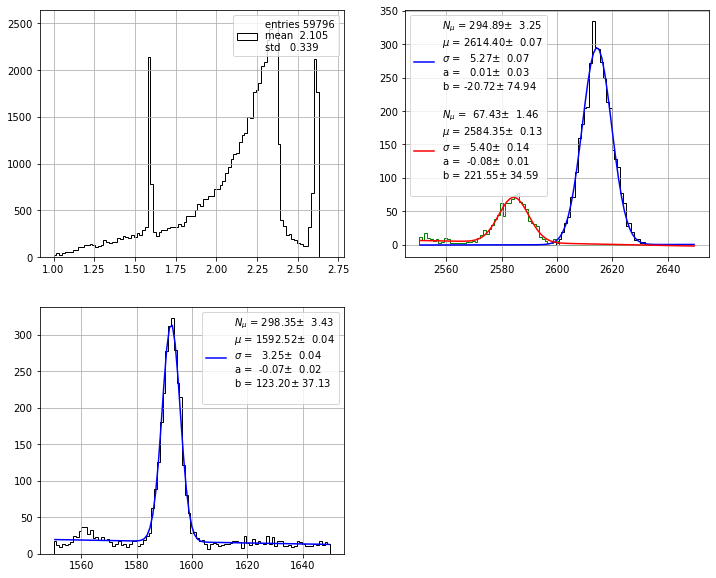

In [9]:
enes   = 1e3 * ut.remove_nan(calib.track0_E.values) # energy in keV and remove NaN

calpars = []

subplot = pltext.canvas(4)

subplot(1)
pltext.hist(calib.track0_E, 100, range = (1., 2.7));

subplot(2)
erange = (2600, 2650) 
guess  = (1e3, 2615, 20., 20., 0.)
bins   = np.linspace(2550, 2650, 100) 
pars, cpars = efit(enes, bins, erange, guess);
calpars.append( (pars, cpars))
erange = (2550-50, 2650 - 50) 
guess  = (1e2, 2615 - 50, 20., 20., 0.)
pars, cpars  = efit(enes, bins, erange, guess);


subplot(3)
erange = (1550, 1650) 
bins   = np.linspace(*erange, 100) 
guess  = (1e3, 1560, 20., 20., 0.)
pars, cpars = efit(enes, bins, erange, guess)
calpars.append( (pars, cpars))

## Other Tl peaks

Study the energy of track-1. 

Identify the peaks.

Fit then to a gaussian.

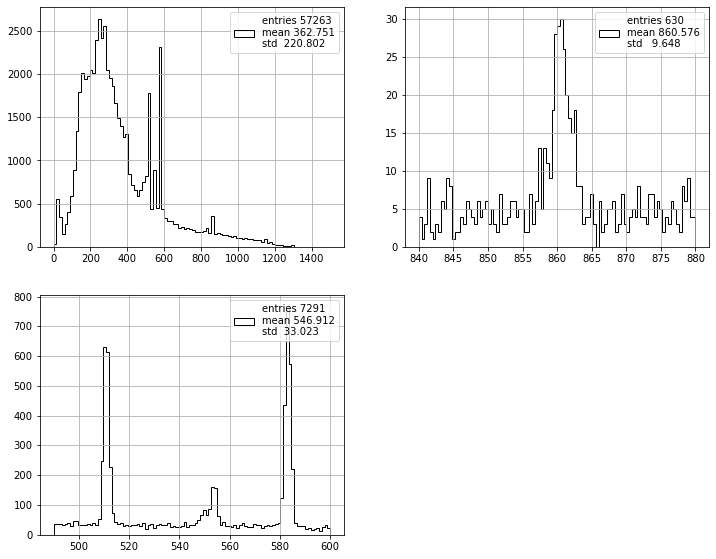

In [12]:
enes   = 1e3 * ut.remove_nan(calib.track1_E.values) # energy in keV and remove NaN

subplot = pltext.canvas(6)

subplot(1)
pltext.hist(enes, 100, range = (0., 1500.));

subplot(2)
erange = (840, 880.) 
pltext.hist(enes, 100, range = erange);
#bins   = np.linspace(*erange, 80) 
#guess  = (1e2, 860, 5., 0., 0.)
#pars, cpars = efit(enes, bins, erange, guess)
#calpars.append( (pars, cpars))

subplot(3)
xrange  = (490., 600.) 
pltext.hist(enes, 100, range = xrange);



## Energy Scale calibration

Relate the measured peaks positions to the tabulated one. 

Fit to a line.

If there are deviation respect unity use this line to calibrate your detector.


### Additional notes

These are the decay diagrams of 214Bi and 208Tl. 

Several lines can be observed in the total energy and track-0 and track-1 energies. 

Notice that the 1.615 MeV gamma can produrce electron-positron pairs and a double-scape peak when the photons produced by the positron capture scape the detector, the double-scape peak has an energy of $1.615 - 2 \; 0.511$ MeV


<img src="img/214-Bi-and-208-Tl-decay-diagrams.png" width="800" height="400">